In [2]:
import os
import pandas as pd
import sys

from dotenv import load_dotenv
from openai import AzureOpenAI

from langchain_openai import AzureChatOpenAI
from langchain.schema import HumanMessage

import csv
import time
from datetime import date, datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

print('Python version:', sys.version)
print('Python executable:', sys.executable)
print('pandas version:', pd.__version__)
print('\nCurrent working directory:', os.getcwd())


Python version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
Python executable: c:\Users\Denis_Davydov2\miniconda3_25\python.exe
pandas version: 2.3.1

Current working directory: c:\Users\Denis_Davydov2\OneDrive\Scipts\Py_Scripts\EPAM\Prophet\AI_skills


In [ ]:
%cd C:\\Users\\Denis_Davydov2\\OneDrive\\Scipts\\Py_Scripts\\EPAM\\Prophet\\AI_skills
print('\nCurrent working directory:', os.getcwd())

C:\Users\Denis_Davydov2\OneDrive\Scipts\Py_Scripts\EPAM\Prophet\AI_skills


'C:\\Users\\Denis_Davydov2\\OneDrive\\Scipts\\Py_Scripts\\EPAM\\Prophet\\AI_skills'

# Get texts (Innoreader)

In [6]:
# Get data Inoreader 2025
file_path = 'C:\\Users\\Denis_Davydov2\\OneDrive - EPAM\\Prophet_AI_docs\\Datasets\\AI_skills\\'
file_name = 'Inoreader_all_2025-10-29.csv'


inoreader = pd.read_csv(file_path+file_name)
print("File read: ", file_name)

print('From: ', min(inoreader['date_published']))
print('To: ', max(inoreader['date_published']))

tokens_total = inoreader['token_count'].sum()
print("Total tokens", tokens_total)
inoreader

File read:  Inoreader_all_2025-10-29.csv
From:  2025-08-02 02:01:31+00:00
To:  2025-10-28 15:00:33+00:00
Total tokens 3654020


,title,url,content_html,date_published,token_count
0,Finding return on AI investments across indust...,https://www.technologyreview.com/2025/10/28/11...,The market is officially three years post Chat...,2025-10-28 15:00:33+00:00,1241
1,OpenAI completed its for-profit restructuring ...,https://www.theverge.com/news/807875/openai-mi...,Microsoft Chairman and Chief Executive Office...,2025-10-28 13:38:55+00:00,557
2,Tech chiefs tell Trump to call off troops – wi...,https://www.theguardian.com/technology/2025/oc...,In this week’s newsletter: Silicon Valley bill...,2025-10-28 13:22:19+00:00,253
3,Adobe Max 2025: all the latest creative tools ...,https://www.theverge.com/news/807867/adobe-max...,Adobe has kicked off its annual Max design co...,2025-10-28 13:16:17+00:00,245
4,Fast vs. Slow: How (and When) to Make Models T...,https://pub.towardsai.net/fast-vs-slow-how-and...,Everyone in the Room Went “Hmm”! Except me…Our...,2025-10-28 12:26:53+00:00,1921
...,...,...,...,...,...
2798,"NYT Connections hints today: Clues, answers fo...",https://mashable.com/article/nyt-connections-h...,Connections is the one of the most popular New...,2025-08-02 03:49:32+00:00,758
2799,"Wordle today: Answer, hints for August 2, 2025",https://mashable.com/article/wordle-today-answ...,"Oh hey there! If you're here, it must be time ...",2025-08-02 03:49:32+00:00,747
2800,"NYT Strands hints, answers for August 2, 2025",https://mashable.com/article/strands-nyt-hint-...,"If you're reading this, you're looking for a l...",2025-08-02 03:49:32+00:00,436
2801,The Whole Story of MDP in RL,https://pub.towardsai.net/the-whole-story-of-m...,Understand what Markov Decision Processes are ...,2025-08-02 02:01:31+00:00,1697


In [38]:
inoreader2025 = inoreader2025[inoreader2025['token_count'] >199]
print("Rows:", len(inoreader2025))
tokens_total = inoreader2025['token_count'].sum()
print("Total tokens", tokens_total)
inoreader2025

NameError: name 'inoreader2025' is not defined

## Check tockens distribution

In [68]:
pd.set_option('display.max_colwidth', None)
print(inoreader2025['content_html'][510:511])
pd.reset_option('display.max_colwidth')

510     Eufy’s FamiLock smart lock features an integrated video screen and a neat palm unlock option. | Photo: Jennifer Pattison Tuohy / The Verge Eufy's FamiLock S3 Max ($399) is a multitasking workhorse. Launched earlier this year, it combines a smart lock and video doorbell in one, and it's one of the first locks with a digital peephole and a wave-to-unlock function. It also has a keyway, keypad, and Matter support, so it works with all the major smart home platforms (the lock portion at least). It's a beast of a door lock, and it screams high tech sitting on your front door. My favorite feature is the integrated video screen, which shows a live feed of who is on the other side of the door without you having to pull out your phone. If you have a peephole or a window in your door, … Read the full story at The Verge.
Name: content_html, dtype: object


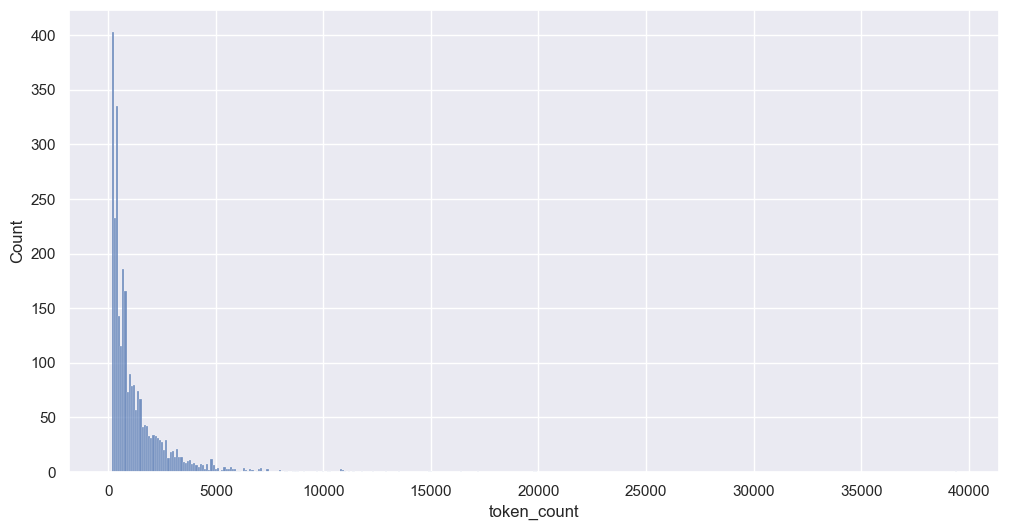

Min token count 150
Max token count 39457


In [5]:
plt.figure(figsize = (12,6))
sns.histplot(data=inoreader, x='token_count', binwidth=100)
plt.show()

print("Min token count", inoreader['token_count'].min())
print("Max token count", inoreader['token_count'].max())

## Cut text (up to token limits)

In [6]:
import tiktoken

def enforce_max_tokens(
    df,
    max_tokens=7500,
    content_col="content_html",
    token_col="token_count",
    encoding_name="cl100k_base"
):
    enc = tiktoken.get_encoding(encoding_name)
    
    # Identify rows where token count exceeds the max_tokens limit
    over_mask = df[token_col].fillna(0) > max_tokens

    def truncate_text(text):
        if not isinstance(text, str):
            return text
        ids = enc.encode(text, disallowed_special=())
        if len(ids) <= max_tokens:
            return text
        return enc.decode(ids[:max_tokens])

    # Truncate only rows that are over the limit
    df.loc[over_mask, content_col] = df.loc[over_mask, content_col].apply(truncate_text)
    
    # Recompute token counts for truncated rows (accurate and ensures <= max_tokens)
    df.loc[over_mask, token_col] = df.loc[over_mask, content_col].apply(
        lambda x: len(enc.encode(x, disallowed_special=())) if isinstance(x, str) else 0
    )
    
    # Optional safety check
    assert (df[token_col] <= max_tokens).all(), "Some rows still exceed the token limit."
    
    return df


# Run the function
texts_cuted = enforce_max_tokens(inoreader, max_tokens=7500, encoding_name="cl100k_base")
tokens_total = texts_cuted['token_count'].sum()
print("Total tokens", tokens_total)
print("Max token count", texts_cuted['token_count'].max())
texts_cuted

Total tokens 3497736
Max token count 7500


,title,url,content_html,date_published,token_count
0,Finding return on AI investments across indust...,https://www.technologyreview.com/2025/10/28/11...,The market is officially three years post Chat...,2025-10-28 15:00:33+00:00,1241
1,OpenAI completed its for-profit restructuring ...,https://www.theverge.com/news/807875/openai-mi...,Microsoft Chairman and Chief Executive Office...,2025-10-28 13:38:55+00:00,557
2,Tech chiefs tell Trump to call off troops – wi...,https://www.theguardian.com/technology/2025/oc...,In this week’s newsletter: Silicon Valley bill...,2025-10-28 13:22:19+00:00,253
3,Adobe Max 2025: all the latest creative tools ...,https://www.theverge.com/news/807867/adobe-max...,Adobe has kicked off its annual Max design co...,2025-10-28 13:16:17+00:00,245
4,Fast vs. Slow: How (and When) to Make Models T...,https://pub.towardsai.net/fast-vs-slow-how-and...,Everyone in the Room Went “Hmm”! Except me…Our...,2025-10-28 12:26:53+00:00,1921
...,...,...,...,...,...
2798,"NYT Connections hints today: Clues, answers fo...",https://mashable.com/article/nyt-connections-h...,Connections is the one of the most popular New...,2025-08-02 03:49:32+00:00,758
2799,"Wordle today: Answer, hints for August 2, 2025",https://mashable.com/article/wordle-today-answ...,"Oh hey there! If you're here, it must be time ...",2025-08-02 03:49:32+00:00,747
2800,"NYT Strands hints, answers for August 2, 2025",https://mashable.com/article/strands-nyt-hint-...,"If you're reading this, you're looking for a l...",2025-08-02 03:49:32+00:00,436
2801,The Whole Story of MDP in RL,https://pub.towardsai.net/the-whole-story-of-m...,Understand what Markov Decision Processes are ...,2025-08-02 02:01:31+00:00,1697


In [20]:
blog_texts = texts_cuted.copy()
#blog_texts = texts_cuted.head(25).copy()
blog_texts = blog_texts.iloc[2269:]


tokens_total = blog_texts['token_count'].sum()
print("Total tokens", tokens_total)
print("Max token count", blog_texts['token_count'].max())


blog_texts['content'] = blog_texts['title']+ '\n'+ blog_texts['content_html']
blog_texts = blog_texts[['title', 'content', 'date_published']]
blog_texts = blog_texts.reset_index().rename(columns={"index": "id"})


blog_texts

Total tokens 598594
Max token count 7500


,id,title,content,date_published
0,2269,Is Perplexity AI’s $34.5b Chrome bid a strateg...,Is Perplexity AI’s $34.5b Chrome bid a strateg...,2025-08-18 14:50:04+00:00
1,2270,The AI future is too scary even for James Came...,The AI future is too scary even for James Came...,2025-08-18 14:20:40+00:00
2,2271,Claude AI will end ‘persistently harmful or ab...,Claude AI will end ‘persistently harmful or ab...,2025-08-18 14:18:57+00:00
3,2272,MSNBC is becoming ‘My Source News Opinion World’,MSNBC is becoming ‘My Source News Opinion Worl...,2025-08-18 13:58:02+00:00
4,2273,We used AI to analyse three cities. It’s true:...,We used AI to analyse three cities. It’s true:...,2025-08-18 13:10:41+00:00
...,...,...,...,...
529,2798,"NYT Connections hints today: Clues, answers fo...","NYT Connections hints today: Clues, answers fo...",2025-08-02 03:49:32+00:00
530,2799,"Wordle today: Answer, hints for August 2, 2025","Wordle today: Answer, hints for August 2, 2025...",2025-08-02 03:49:32+00:00
531,2800,"NYT Strands hints, answers for August 2, 2025","NYT Strands hints, answers for August 2, 2025\...",2025-08-02 03:49:32+00:00
532,2801,The Whole Story of MDP in RL,The Whole Story of MDP in RL\nUnderstand what ...,2025-08-02 02:01:31+00:00


## LLM Models

In [3]:
# === Load Environment Variables ===
load_dotenv()  # Loads variables from .env file into environment

# Retrieve database connection parameters from environment variables
DIAL_API_KEY = os.getenv('DIAL_API_KEY')

#print(DIAL_API_KEY)

## Azure models list

In [5]:

client = AzureOpenAI(
    api_version="2025-04-01-preview",
    azure_endpoint="https://ai-proxy.lab.epam.com",
    api_key=DIAL_API_KEY,
)
models = client.models.list()
models

def models_to_dataframe(models):
    def _desc(m):
        dk = getattr(m, "description_keywords", "")
        if isinstance(dk, (list, tuple)):
            return ", ".join(map(str, dk))
        return "" if dk is None else str(dk)
    
    def _max_tokens(m):
        limits = getattr(m, "limits", {}) or {}
        return limits.get("max_total_tokens", "")

    def _pricing_input(m):
        inp = getattr(m, "pricing", {}) or {}
        inp_tokens = inp.get("prompt", "")
        try:
            return float(inp_tokens) * 1000000
        except ValueError:
            return None

    def _pricing_output(m):
        out = getattr(m, "pricing", {}) or {}
        out_tokens = out.get("completion", "")
        try:
            return float(out_tokens) * 1000000
        except ValueError:
            return None

    
    rows = [{
        "ID": m.id,
        "Name": getattr(m, "display_name", ""),
        "Version": getattr(m, "display_version", ""),
        "Description": _desc(m),
        "Max tokens": _max_tokens(m),
        "Input 1mt": _pricing_input(m),
        "Output 1mt": _pricing_output(m),
    } for m in models.data]
        
    return pd.DataFrame(rows, columns=["ID", "Name", "Version", "Description", "Max tokens", "Input 1mt", "Output 1mt"])

models_tab = models_to_dataframe(models)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(models_tab)
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows', None)

,ID,Name,Version,Description,Max tokens,Input 1mt,Output 1mt
0,dall-e-3,OpenAI DALL-E 3,3,"Image Generation, Azure",,0.000000,40000.00
1,gpt-35-turbo-0125,OpenAI GPT-3.5 Turbo (Legacy),0125,"Text Generation, Functions, Azure",16385,0.500000,1.50
2,gpt-35-turbo-1106,OpenAI GPT-3.5 Turbo (Legacy),1106,"Text Generation, Functions, Azure",16385,1.000000,2.00
3,gpt-35-turbo,OpenAI GPT-3.5 Turbo (Legacy),Latest,"Text Generation, Functions, Azure",16385,0.500000,1.50
4,gpt-4,OpenAI GPT-4 Latest,GPT-4o 2024-11-20,"Text Generation, Image Recognition, Azure, Functions, Structured Output",,2.500000,10.00
5,gpt-4-turbo-2024-04-09,OpenAI GPT-4 Turbo (Legacy),2024-04-09,"Text Generation, Functions, Azure",128000,10.000000,30.00
6,gpt-4-turbo,OpenAI GPT-4 Turbo (Legacy),Latest,"Text Generation, Functions, Azure",128000,10.000000,30.00
7,gpt-4o-2024-05-13,OpenAI GPT-4o,2024-05-13,"Text Generation, Image Recognition, Azure, Functions",128000,5.000000,15.00
8,gpt-4o-2024-08-06,OpenAI GPT-4o,2024-08-06,"Text Generation, Image Recognition, Azure, Functions, Structured Output",128000,2.750000,11.00
9,gpt-4o-2024-11-20,OpenAI GPT-4o,2024-11-20,"Text Generation, Image Recognition, Azure, Functions, Structured Output",128000,2.500000,10.00


## AzureOpenAI API (with batches)

### Extract topics

In [24]:
import time
import csv
import pandas as pd
from typing import List, Dict

# LangChain + Azure OpenAI
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser



# --- Azure OpenAI Setup ---
AZURE_OPENAI_ENDPOINT = "https://ai-proxy.lab.epam.com"

#AZURE_OPENAI_DEPLOYMENT = "gpt-5-mini-2025-08-07"
#AZURE_OPENAI_DEPLOYMENT = "gpt-5-nano-2025-08-07"
#AZURE_OPENAI_DEPLOYMENT = 'anthropic.claude-v3-5-sonnet'
#AZURE_OPENAI_DEPLOYMENT = "gemini-2.5-flash"
#AZURE_OPENAI_DEPLOYMENT = "gemini-2.5-flash-lite"
#AZURE_OPENAI_DEPLOYMENT = "gemini-2.5-pro"
#AZURE_OPENAI_DEPLOYMENT = "gemini-2.5-pro-google-search"
AZURE_OPENAI_DEPLOYMENT = "gemini-2.0-flash-lite"
#AZURE_OPENAI_DEPLOYMENT = "anthropic.claude-opus-4-20250514-v1:0"
#AZURE_OPENAI_DEPLOYMENT = 'anthropic.claude-v3-5-sonnet'
#AZURE_OPENAI_DEPLOYMENT = "amazon.titan-tg1-large"


# --- Config ---
OUTPUT_FILE = f"topics_inor_{AZURE_OPENAI_DEPLOYMENT}_{date.today()}.csv"
BATCH_SIZE = 10
SLEEP_BETWEEN_CALLS = 1.0

# --- Prompt ---
SYSTEM_MESSAGE = "You are a talent recruiter for AI development team"

PROMPT_TEMPLATE = """ 
As a recruiter for AI developers, identify AI-related skills.
Read the AI news below and extract AI-related skills that are explicitly mentioned or strongly implied by the context.
Examples of AI-related skills: Prompt Engineering, Vector Search, RAG (Retrieval-Augmented Generation), LangChain, TensorFlow, PyTorch, Reinforcement Learning, Computer Vision, NLP, Image Classification, LLM APIs, KServe, DALL·E, Midjourney, Stable Diffusion, Memory-Efficient Training.

Return only a comma-separated list of skills.
Use concise, canonical skill names. Remove duplicates. Do not include any extra text or punctuation.
If no AI-related skills are identified, return None.
Text:
{text}

Answer:
"""

# --- Build LangChain components ---

prompt = ChatPromptTemplate.from_messages([
("system", SYSTEM_MESSAGE),
("human", PROMPT_TEMPLATE),
])

model = AzureChatOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=DIAL_API_KEY,
    api_version="2025-04-01-preview",
    azure_deployment=AZURE_OPENAI_DEPLOYMENT,
    #temperature=0,
)

parser = StrOutputParser()
chain = prompt | model | parser

# --- Helper: batching ---
def batch_iterable(items: List[Dict], size: int):
    for i in range(0, len(items), size):
        yield items[i : i + size]

# --- Prepare inputs from blog_texts ---
# Keep only needed columns and drop rows with missing content
df = blog_texts[["id", "content"]].dropna(subset=["content"]).copy()

# Build payloads for the chain
payloads = [{"id": row.id, "text": row.content} for row in df.itertuples(index=False)]


ts1 = datetime.now() 
print('Start: ', datetime.now())

# --- Process in batches ---
results = []
total_batches = (len(payloads) + BATCH_SIZE - 1) // BATCH_SIZE
processed_batches = 0
print(f"Processed batches: 0/{total_batches}", end="", flush=True)

for batch in batch_iterable(payloads, BATCH_SIZE):
    try:
        # chain.batch expects list of dicts matching prompt variables; we pass only {'text': ...}
        batch_inputs = [{"text": item["text"]} for item in batch]
        outputs = chain.batch(batch_inputs)  # returns list[str], same order as inputs

        # Collect results with corresponding ids
        for item, topics in zip(batch, outputs):
            topics_line = (topics or "").strip().replace("\n", " ").strip()
            results.append({"id": item["id"], "topics": topics_line})
    except Exception as e:
        print(f" Error processing batch: {e}")
        for item in batch:
            results.append({"id": item["id"], "topics": ""})

    finally:
        # display process status
        processed_batches += 1
        print(f"\rProcessed batches: {processed_batches}/{total_batches}", end="", flush=True)
        time.sleep(SLEEP_BETWEEN_CALLS)
print()

# --- Save results ---
with open(OUTPUT_FILE, "w", newline="", encoding="utf-8") as outfile:
    writer = csv.DictWriter(outfile, fieldnames=["id", "topics"])
    writer.writeheader()
    writer.writerows(results)


ts2 = datetime.now() 
print('Finish: ', ts2)
print('Processing time: ', ts2-ts1)
print("Text processed:", len(results))

print(f"✅ Extraction complete. Results saved to {OUTPUT_FILE}")

Start:  2025-11-01 12:28:00.688044
Processed batches: 54/54
Finish:  2025-11-01 12:33:16.738215
Processing time:  0:05:16.050199
Text processed: 534
✅ Extraction complete. Results saved to topics_inor_gemini-2.0-flash-lite_2025-11-01.csv

Finish:  2025-11-01 12:33:16.738215
Processing time:  0:05:16.050199
Text processed: 534
✅ Extraction complete. Results saved to topics_inor_gemini-2.0-flash-lite_2025-11-01.csv


### Check result

In [ ]:



pd.set_option('display.max_colwidth', None)
print(blog_texts['content'][10:11])
pd.reset_option('display.max_colwidth')


In [32]:
gpt = results
topics_gpt = pd.DataFrame(gpt, columns=['id', 'topics'])

pd.set_option('display.max_colwidth', None)
display(topics_gpt)
pd.reset_option('display.max_colwidth')


print("Empty rows: ",topics_gpt['topics'].isna().sum())


,id,topics
0,2200,None
1,2201,"Large Language Models,Prompt Engineering,Long-context LLMs,Multimodal AI,Multimodal Reasoning,Computer Vision,Vision-Language Models,Visual Question Answering,Medical AI,Medical Imaging,Speech Recognition,Speech Translation,Voice AI,Conversational AI,Chatbot Development,AI Agents,Agent Orchestration,Tool Integration,Function Calling,LangGraph,Model Context Protocol,Retrieval-Augmented Generation,Semantic Search,Vector Search,Embeddings,Vector Indexing,FAISS,Qdrant,LlamaIndex,Hybrid Search,Information Retrieval,Reinforcement Learning,Policy Optimization,Supervised Fine-Tuning,Instruction Tuning,Reward Modeling,Fine-tuning,Mixture of Experts,Parameter-efficient Training,Self-supervised Learning,Image Generation,Autoregressive Image Generation,Image Synthesis,Image Editing,Flow Matching,Time Series Modeling,Dataset Creation,Data Curation,MLOps,Model Monitoring,MLflow,FastAPI,API Development,Deployment,Production ML Engineering,Multilingual NLP,Code Generation,LLM APIs,Passage Ranking,Document OCR,Layout Analysis,Document Understanding"
2,2202,"Fraud Detection, Bot Detection, Anomaly Detection, Behavioral Analytics, Identity and Access Management, Synthetic Identity Detection, Anti-Abuse Systems, Cybersecurity, Network Security"
3,2203,None
4,2204,"JAX, Google Cloud TPU, XLA, MaxText, Flax, Optax, Orbax, Mixture of Experts (MoE), Megatron-LM, FSDP, SPMD, Distributed Training, High-Performance Computing (HPC), Grain, XPK, Kubernetes, Google Kubernetes Engine (GKE), Hugging Face Hub, Megablocks, Group GEMM, Sparse Matrix Multiplication, MoE Routing, Load Balancing Loss, Tokenization, Sequence Modeling, Data Pipelines, Data Blending, Learning Rate Scheduling, Pretraining, Large Language Models (LLMs), Model Architecture Design, Model Conversion (dense to MoE), Code Modeling, Natural Language Processing (NLP)"
...,...,...
598,2798,"Natural Language Processing,Lexical Semantics,Synonym/Antonym Detection,Word Sense Disambiguation,Semantic Similarity,Word Embeddings,Vector Search,Clustering,Text Classification,Knowledge Representation"
599,2799,None
600,2800,"Computer Vision,Image Processing,Image Editing,Image Segmentation,Image Inpainting,Background Removal,Object Removal,Image Enhancement,Image Annotation,Style Transfer,Color Correction,Image Augmentation"
601,2801,"Reinforcement Learning,Markov Decision Processes (MDP),Partially Observable Markov Decision Process (POMDP),Probabilistic Modeling,Stochastic Modeling,State Representation,Dynamics Modeling,Reward Engineering,Environment Simulation,Gridworld Environments"


Empty rows:  0


## Save results

In [47]:

file_path = r'C:\Users\Denis_Davydov2\OneDrive - EPAM\Prophet_AI_docs\Datasets\AI_skills'
file_name = f'topics_all_{date.today()}.csv'

inoreader_topics.to_csv(file_path + '\\' + file_name, index=False)
print(f"File {file_name} \nuploaded to:", file_path)
print("Total rows", len(inoreader_topics))

File topics_all_2025-10-31.csv 
uploaded to: C:\Users\Denis_Davydov2\OneDrive - EPAM\Prophet_AI_docs\Datasets\AI_skills
Total rows 2195


In [39]:
# Get  dataset 1
file_path = 'C:\\Users\\Denis_Davydov2\\OneDrive\\Scipts\\Py_Scripts\\EPAM\\Prophet\\AI_skills\\'
file_name = 'topics_gpt-5-mini-2025-08-07_2025-10-29.csv'


inoreader_topics_1 = pd.read_csv(file_path+file_name)
print("File read: ", file_name)
inoreader_topics_1.dropna(subset=['topics'], inplace=True)
inoreader_topics_1

File read:  topics_gpt-5-mini-2025-08-07_2025-10-29.csv


,id,topics
0,0,"Generative AI,Agentic AI,Prompt Engineering,Re..."
1,1,"AGI, AI Resilience, AI Governance, AI Policy, ..."
2,2,"Computer Vision, Image Recognition, Object Det..."
3,3,"Generative AI,Adobe Firefly,Prompt Engineering..."
4,4,"Prompt Engineering, Chain-of-Thought Prompting..."
...,...,...
2193,2193,"Machine Translation, Automatic Speech Recognit..."
2194,2194,"OCR,Computer Vision,Document Layout Analysis,O..."
2195,2195,"Generative AI,Amazon Bedrock,Multimodal Models..."
2197,2197,"World Models,Generative Models,3D Environment ..."


In [37]:
# Get  dataset 2
file_path = 'C:\\Users\\Denis_Davydov2\\OneDrive\\Scipts\\Py_Scripts\\EPAM\\Prophet\\AI_skills\\'
file_name = 'topics_gpt-5-mini-2025-08-07_2025-10-30_2.csv'


inoreader_topics_2 = pd.read_csv(file_path+file_name)
print("File read: ", file_name)
inoreader_topics_2

File read:  topics_gpt-5-mini-2025-08-07_2025-10-30_2.csv


,id,topics
0,2200,NaN
1,2201,"Large Language Models,Prompt Engineering,Long-..."
2,2202,"Fraud Detection, Bot Detection, Anomaly Detect..."
3,2203,NaN
4,2204,"JAX, Google Cloud TPU, XLA, MaxText, Flax, Opt..."
...,...,...
598,2798,"Natural Language Processing,Lexical Semantics,..."
599,2799,NaN
600,2800,"Computer Vision,Image Processing,Image Editing..."
601,2801,"Reinforcement Learning,Markov Decision Process..."


In [42]:
# Combine
inoreader_topics = pd.concat([inoreader_topics_1, inoreader_topics_2])
inoreader_topics

,id,topics
0,0,"Generative AI,Agentic AI,Prompt Engineering,Re..."
1,1,"AGI, AI Resilience, AI Governance, AI Policy, ..."
2,2,"Computer Vision, Image Recognition, Object Det..."
3,3,"Generative AI,Adobe Firefly,Prompt Engineering..."
4,4,"Prompt Engineering, Chain-of-Thought Prompting..."
...,...,...
598,2798,"Natural Language Processing,Lexical Semantics,..."
599,2799,NaN
600,2800,"Computer Vision,Image Processing,Image Editing..."
601,2801,"Reinforcement Learning,Markov Decision Process..."


# Get smol.ai texts

In [4]:
# Get data Inoreader 2025
file_path = 'C:\\Users\\Denis_Davydov2\\OneDrive - EPAM\\Prophet_AI_docs\\Datasets\\AI_skills\\'
file_name = 'smolai_texts_2025-10-31.csv'


smolai = pd.read_csv(file_path+file_name)
print("File read: ", file_name)
smolai
# Rename columns to match expected format
smolai = smolai.rename(columns={
    'content_deduped': 'content',
    'date_extracted': 'date_published'
})
print("Columns renamed")

smolai = smolai.reset_index().rename(columns={"index": "id"})

print('From: ', min(smolai['date_published']))
print('To: ', max(smolai['date_published']))

tokens_total = smolai['token_count'].sum()
print("Total tokens", tokens_total)
smolai

File read:  smolai_texts_2025-10-31.csv
Columns renamed
From:  2024-04-01
To:  2025-10-29
Total tokens 2171701


,id,title,date_published,content,token_count
0,0,AdamW -> AaronD?,2024-04-01,Capabilities and LimitationsLimitations of cur...,1666
1,1,Not much happened today,2024-04-02,Models and ArchitecturesDBRX : person_019 note...,2989
2,2,ReALM: Reference Resolution As Language Modeling,2024-04-03,all recaps done by with Haiku.Anthropic Resear...,1897
3,3,"Cohere Command R+, Anthropic Claude Tool Use, ...",2024-04-04,all recaps done by with Haiku.Cohere Command R...,1908
4,4,Mixture of Depths: Dynamically allocating comp...,2024-04-05,Models and ArchitecturesGoogles Training LLMs ...,2233
...,...,...,...,...,...
398,398,not much happened today,2025-10-23,"Agent ops, observability, and real-world envsL...",4370
399,399,not much happened today,2025-10-24,Serving and Production Platforms: vLLM x NVIDI...,4874
400,400,MiniMax M2 230BA10B — 8% of Claude Sonnet's pr...,2025-10-27,MiniMax M2 open-weights release: sparse MoE fo...,5146
401,401,OpenAI completes Microsoft + For-profit restru...,2025-10-28,"OpenAIs new structure, Microsoft deal, and ope...",5946


## Tokens distribution

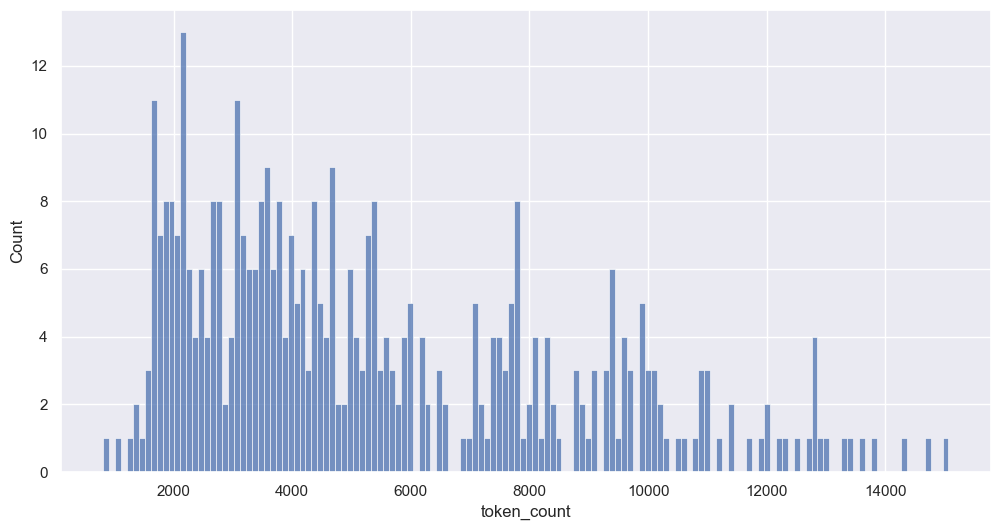

Min token count 812
Max token count 15062


In [5]:
plt.figure(figsize = (12,6))
sns.histplot(data=smolai, x='token_count', binwidth=100)
plt.show()

print("Min token count", smolai['token_count'].min())
print("Max token count", smolai['token_count'].max())

## Extract topics

In [6]:
# === Load Environment Variables ===
load_dotenv()  # Loads variables from .env file into environment

# Retrieve database connection parameters from environment variables
DIAL_API_KEY = os.getenv('DIAL_API_KEY')

#print(DIAL_API_KEY)

In [7]:
texts = smolai.copy()
#blog_texts = texts_cuted.head(25).copy()
#texts = texts.iloc[240:]
print("Rows selected:", len(texts))
texts

Rows selected: 403


,id,title,date_published,content,token_count
0,0,AdamW -> AaronD?,2024-04-01,Capabilities and LimitationsLimitations of cur...,1666
1,1,Not much happened today,2024-04-02,Models and ArchitecturesDBRX : person_019 note...,2989
2,2,ReALM: Reference Resolution As Language Modeling,2024-04-03,all recaps done by with Haiku.Anthropic Resear...,1897
3,3,"Cohere Command R+, Anthropic Claude Tool Use, ...",2024-04-04,all recaps done by with Haiku.Cohere Command R...,1908
4,4,Mixture of Depths: Dynamically allocating comp...,2024-04-05,Models and ArchitecturesGoogles Training LLMs ...,2233
...,...,...,...,...,...
398,398,not much happened today,2025-10-23,"Agent ops, observability, and real-world envsL...",4370
399,399,not much happened today,2025-10-24,Serving and Production Platforms: vLLM x NVIDI...,4874
400,400,MiniMax M2 230BA10B — 8% of Claude Sonnet's pr...,2025-10-27,MiniMax M2 open-weights release: sparse MoE fo...,5146
401,401,OpenAI completes Microsoft + For-profit restru...,2025-10-28,"OpenAIs new structure, Microsoft deal, and ope...",5946


In [8]:
import time
import csv
import pandas as pd
from typing import List, Dict

# LangChain + Azure OpenAI
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser



# ---------- Azure OpenAI Setup ------------------------------------
AZURE_OPENAI_ENDPOINT = "https://ai-proxy.lab.epam.com"

#AZURE_OPENAI_DEPLOYMENT = "gpt-5-mini-2025-08-07"
#AZURE_OPENAI_DEPLOYMENT = "gpt-5-nano-2025-08-07"
AZURE_OPENAI_DEPLOYMENT = 'anthropic.claude-v3-5-sonnet'
#AZURE_OPENAI_DEPLOYMENT = "gemini-2.5-flash"
#AZURE_OPENAI_DEPLOYMENT = "gemini-2.5-pro"

# ------------- Config ---------------------------------------------
OUTPUT_FILE = f"topics_smol_{AZURE_OPENAI_DEPLOYMENT}_{date.today()}.csv"
BATCH_SIZE = 10
SLEEP_BETWEEN_CALLS = 1.0

# ========= PROMPT =======================================
SYSTEM_MESSAGE = "You are a talent recruiter for AI development team"

PROMPT_TEMPLATE = """ 
As a recruiter for AI developers, identify AI-related skills.
Read the AI news below and extract AI-related skills that are explicitly mentioned or strongly implied by the context.
Examples of AI-related skills: Prompt Engineering, Vector Search, RAG (Retrieval-Augmented Generation), LangChain, TensorFlow, PyTorch, Reinforcement Learning, Computer Vision, NLP, Image Classification, LLM APIs, KServe, DALL·E, Midjourney, Stable Diffusion, Memory-Efficient Training.

Return only a comma-separated list of skills.
Use concise, canonical skill names. Remove duplicates. Do not include any extra text or punctuation.
If no AI-related skills are identified, return None.
Text:
{text}

Answer:
"""

# --- Build LangChain components ---

prompt = ChatPromptTemplate.from_messages([
("system", SYSTEM_MESSAGE),
("human", PROMPT_TEMPLATE),
])

model = AzureChatOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=DIAL_API_KEY,
    api_version="2025-04-01-preview",
    azure_deployment=AZURE_OPENAI_DEPLOYMENT,
    #temperature=0,
)

parser = StrOutputParser()
chain = prompt | model | parser

# --- Helper: batching ---
def batch_iterable(items: List[Dict], size: int):
    for i in range(0, len(items), size):
        yield items[i : i + size]

# --- Prepare inputs from texts ---
# Keep only needed columns and drop rows with missing content
df = texts[["id", "content"]].dropna(subset=["content"]).copy()

# Build payloads for the chain
payloads = [{"id": row.id, "text": row.content} for row in df.itertuples(index=False)]


ts1 = datetime.now() 
print('Start: ', datetime.now())

# --- Process in batches ---
results = []
total_batches = (len(payloads) + BATCH_SIZE - 1) // BATCH_SIZE
processed_batches = 0
print(f"Processed batches: 0/{total_batches}", end="", flush=True)

for batch in batch_iterable(payloads, BATCH_SIZE):
    try:
        # chain.batch expects list of dicts matching prompt variables; we pass only {'text': ...}
        batch_inputs = [{"text": item["text"]} for item in batch]
        outputs = chain.batch(batch_inputs)  # returns list[str], same order as inputs

        # Collect results with corresponding ids
        for item, topics in zip(batch, outputs):
            topics_line = (topics or "").strip().replace("\n", " ").strip()
            results.append({"id": item["id"], "topics": topics_line})
    except Exception as e:
        print(f"Error processing batch: {e}")
        for item in batch:
            results.append({"id": item["id"], "topics": ""})

    finally:
        # display process status
        processed_batches += 1
        print(f"\rProcessed batches: {processed_batches}/{total_batches}", end="", flush=True)
        time.sleep(SLEEP_BETWEEN_CALLS)
print()

# --- Save results ---
with open(OUTPUT_FILE, "w", newline="", encoding="utf-8") as outfile:
    writer = csv.DictWriter(outfile, fieldnames=["id", "topics"])
    writer.writeheader()
    writer.writerows(results)


ts2 = datetime.now() 
print('Finish: ', ts2)
print('Processing time: ', ts2-ts1)
print("Text processed:", len(results))

print(f"✅ Extraction complete. Results saved to {OUTPUT_FILE}")

Start:  2025-11-01 00:10:11.918736
Processed batches: 41/41
Finish:  2025-11-01 00:18:59.858458
Processing time:  0:08:47.939751
Text processed: 403
✅ Extraction complete. Results saved to topics_smol_anthropic.claude-v3-5-sonnet_2025-11-01.csv

Finish:  2025-11-01 00:18:59.858458
Processing time:  0:08:47.939751
Text processed: 403
✅ Extraction complete. Results saved to topics_smol_anthropic.claude-v3-5-sonnet_2025-11-01.csv
